In [1]:
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt

import plotly
import plotly.express as px

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import tqdm
#from functools import lru_cache
#import re
import networkx as nx
from networkx.algorithms import approximation

import MDAnalysis as mda

import scipy
import sklearn
import skimage

#import xml.etree.ElementTree as et
from Bio.PDB import *
import nglview as nv

from timeit import default_timer as timer



# http://nglviewer.org/nglview/latest/api.html
# https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
# https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_notebook/index.html
# https://amber-md.github.io/pytraj/latest/_api/pytraj.html

_ColormakerRegistry()

In [2]:
#contact_matrix = np.loadtxt('/home/lillo/TesiCNTE/CNTE/dataset/contact_matrix.txt')   #laptop
#contact_matrix = np.loadtxt('/home/lillo/Code/Tesi/dataset/contact_matrix.txt')        #fisso
#contact_matrix_single = contact_matrix.reshape(100,100,12,12)

#gromacs_output = open('/home/lillo/Code/Tesi/dataset/dm4500Compl_mix1_K2_1%4500ns.gro') #fisso
#gromacs_output = open('/home/lillo/TesiCNTE/CNTE/dataset/dm4500Compl_mix1_K2_1%4500ns.gro') #laptop

#path = '/home/lillo/Code/Tesi/dataset/dm4500Compl_mix1_K2_1%4500ns.gro' #fisso
path = '/home/lillo/TesiCNTE/CNTE/dataset/dm4500Compl_mix1_K2_1%4500ns.gro' #laptop

# import 2mxu file (beta sheet)

#path_to_mmCIF = open('/home/lillo/TesiCNTE/pdb/2mxu/2mxu.cif')  ## laptop
path_to_pdb = '/home/lillo/TesiCNTE/pdb/2mxu/2mxu.pdb'  ## laptop
#pa_to_pdb = '/home/lillo/TesiCNTE/pdb/2mxu/2mxu.pdb'  ## laptop

#path_to_mmCIF = open('/home/lillo/Code/Tesi/pdb/2mxu/2mxu.cif')  ## fisso
#path_to_pdb = '/home/lillo/Code/Tesi/pdb/2mxu/2mxu.pdb'  ## fisso
#pa_to_pdb = '/home/lillo/Code/Tesi/pdb/2mxu/2mxu.pdb'  ## fisso

seed_1_path = '/home/lillo/TesiCNTE/from_cluster/aggregate1.gro' # laptop
#seed_1_path = '/home/lillo/Code/Tesi/dataset/aggregate1.gro' # Fisso

trj_xtc = '/home/lillo/TesiCNTE/CNTE/trajectory/prd-LDLK12-100mer-out-mol.xtc'  #laptop
trj_gro = '/home/lillo/TesiCNTE/CNTE/trajectory/min-LDLK12-100mer-out-c.gro'  #laptop


In [3]:
# READ .gro FILE AND PREPROCESSING

def clean_gro(path):
    
    
    # open file .gro and return a list with one element per line of the .gro file
    def read_gro(path):
        gromacs_output = open(path)

        gro_file = []
        for line in tqdm.tqdm(gromacs_output):
            gro_file.append(line)



        gromacs_output.close()        

        return gro_file



    # return string in a string with numbers
    def return_if_string(string):
        digits = []
        for i in string:
            if not i.isdigit():
                digits.append(i)

        string = ''.join(digits)

        return string


    # return numbers in a string with numbers
    def return_if_digit(string):
        digits = []
        for i in string:
            if i.isdigit():
                digits.append(i)

        string = ''.join(digits)

        return string


    # remove first, second and last lines from gro_file and reorder information
    def clean_gro_file(gro_file):
        cleaned_gro_file = []
        for aminoacid in tqdm.tqdm(gro_file[2:-1]):
            splitted = aminoacid.split()
            position_in_peptide = return_if_digit(splitted[0])
            residue = return_if_string(splitted[0])
            index = splitted[2]
            x = splitted[3]
            y = splitted[4]
            z = splitted[5]
            cleaned_gro_file.append([index, position_in_peptide, residue, x, y, z])
        return cleaned_gro_file
    
    
    
    gro_file = read_gro(path)
    cleaned_gro_file = clean_gro_file(gro_file)

    return cleaned_gro_file


# create coordinate dict from cleaned_gro_file
def get_coordinate_dict_from_cleaned_gro(cleaned_gro_file):
    
    peptide_lenght_list = []

    temporary_list = []

    # iterate trough cleaned_gro_file
    for residue in cleaned_gro_file:

        # if temporary list just started, add aminoacid position in chain
        if len(temporary_list) == 0:
            temporary_list.append(int(residue[1]))

        else:
            # if position of actual residue is less than last residue
            if temporary_list[-1] > int(residue[1]):

                # append lenght of last peptide to peptide lenght list
                peptide_lenght_list.append(len(temporary_list))

                # empty temporary list
                temporary_list = []

                # append actual residue position
                temporary_list.append(int(residue[1]))

            # if position of actual residue is higher than last residue, ad current residue position
            else:
                temporary_list.append(int(residue[1]))

    # append last peptide lenght to lenght stack
    peptide_lenght_list.append(len(temporary_list))

    # create empty dict for coordinate
    peptide_coordinate_dict = {}

    # create an entry in dict for every peptide in the file
    for peptide in range(len(peptide_lenght_list)):
        peptide_coordinate_dict[peptide] = {}

        # for every residue in lenght peptide, add coordinate x, y, z
        for residue in range(peptide_lenght_list[peptide]):
            peptide_coordinate_dict[peptide][residue] = [float(coordinate) for coordinate in cleaned_gro_file[(peptide * peptide_lenght_list[peptide])+residue][3:]]

    return peptide_coordinate_dict


# compute euclidean distance
def get_euclidean_distance(point_1, point_2):
    
    euclidean_distance = np.sqrt(np.sum([((point_1[0] - point_2[0])**2), ((point_1[1] - point_2[1])**2), ((point_1[2] - point_2[2])**2)]))

    return euclidean_distance

# compute distance map between two peptides
def compute_distance_map(coordinate_dict, peptide_1, peptide_2):

    distance_map = []
    for amino_1 in coordinate_dict[peptide_1]:
        coordinate_1 = coordinate_dict[peptide_1][amino_1]
        
        distance_map.append([amino_1])
        
        for amino_2 in coordinate_dict[peptide_2]:
            coordinate_2 = coordinate_dict[peptide_2][amino_2]
            
            euclidean_distance = get_euclidean_distance(coordinate_1, coordinate_2)
            distance_map[amino_1].append(euclidean_distance)
        
        del distance_map[amino_1][0]

    distance_map = np.asarray(distance_map)
    
    return distance_map

# compute distance map and return a n_peptide x n_peptide x n_res x n_res array
def compute_distance_maps_from_gro(coordinate_dict):
    
    aggregate_distance_map = []

    #for peptide_1 in tqdm.tqdm(coordinate_dict):
    for peptide_1 in coordinate_dict:
        aggregate_distance_map.append([peptide_1])
        
        #for peptide_2 in tqdm.tqdm(coordinate_dict):
        for peptide_2 in coordinate_dict:
            distance_map = compute_distance_map(coordinate_dict, peptide_1, peptide_2)
            
            aggregate_distance_map[peptide_1].append(distance_map)

        del aggregate_distance_map[peptide_1][0]

    aggregate_distance_array = np.asarray(aggregate_distance_map)
    
    return aggregate_distance_array


# COMPUTE CONTACT MAPS
# TO DO: parametrize the threshold distance in a better way
def compute_contact_maps_as_array(distance_maps_array):
    
# distance between the first and the second aminoacid of the first chain
    intrapeptide_minimum_distance = distance_maps_array[0][0][0][1] 

    contact_map_list = []

    # contact is in a distance uo to 138% of the intrapeptide_minimum_distance
    threshold_distance = (intrapeptide_minimum_distance * 1.5)

    for model_1 in range(distance_maps_array.shape[0]):
        contact_map_list.append([])
        for model_2 in range(distance_maps_array[model_1].shape[0]):

            contact_map_list[model_1].append([])

            if model_1 == model_2:

                contact_map_list[model_1][model_2].extend(np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3])))

            else:

                contact_map = np.zeros((distance_maps_array.shape[2], distance_maps_array.shape[3]))

                for chain_1 in range(distance_maps_array[model_1][model_2].shape[0]):

                    for chain_2 in range(distance_maps_array[model_1][model_2][chain_1].shape[0]):

                        distance = distance_maps_array[model_1][model_2][chain_1][chain_2]

                        if distance < threshold_distance:
                            contact_map[chain_1][chain_2] = 1 #True
                        else:
                            pass

                contact_map_list[model_1][model_2].extend(contact_map)
    
    contact_array = np.asarray(contact_map_list)
            
    return contact_array


#### ANALYSIS

def shift_library_maker(contact_map_to_analyze):
    
    ''' riceve numero di righe e di colonne
    restituisce un array shape((((row + col)*2)-2),row,col).
    ogni slice è una diagonale. Lo stack copre le diagonali su tutta la matrice'''
    
    row = contact_map_to_analyze.shape[0]
    col = contact_map_to_analyze.shape[1]
    
    kron_dict = {}
    kron_list_parallel = []
    kron_list_antiparallel = []
    
    for e in range(-row+1, col):
        array = np.eye(row, col, e)
        kron_list_parallel.append(array)
        kron_list_antiparallel.append(np.fliplr(array))
        
    kron_array_parallel = np.asarray(kron_list_parallel)
    kron_array_antiparallel = np.asarray(kron_list_antiparallel)
    
    kron_dict['parallel'] = kron_array_parallel
    kron_dict['antiparallel'] = kron_array_antiparallel
    
    return kron_dict


def normalized_cross_correlation_function(contact_map):
    '''
    Calculate normalized cross correlation function between a contact map and an ideal map.
    
    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function
                
    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix
                that is matching the contact map
            
            '''
    shift_matrix_library = shift_library_maker(contact_map)
    
    cross_correlation_values = []
    max_val = []
    sum_contact_map = np.sum(contact_map)
    
    if sum_contact_map < 2:
        pass
    
    else:
        for sense in shift_matrix_library:
            for index, z in enumerate(shift_matrix_library[sense]):

                shift_matrix = shift_matrix_library[sense][index]
                sum_shift_matrix = np.sum(shift_matrix)
                ncc_value = (np.sum((contact_map * shift_matrix))/((np.sqrt(sum_contact_map))*(np.sqrt(sum_shift_matrix))))  # normalized cross correlation function of contact matrix and shift matrix
                cross_correlation_values.append([ncc_value, index, sum_contact_map, sense])

            max_val = max(cross_correlation_values) # get only the best match (highest value of ncc)

    return max_val



def normalized_cross_correlation_for_dataset(contact_array):
    '''Calculate normalized cross correlation function between the full contacts map and and the .
    
    Arguments : contact map, as output from get_contact_maps function
                shift_matrix_stack, as output from shift_matrix_maker function
                
    Return : a list [ncc_value, index (in the shift_matrix_stack) of the shift matrix that is matching the contact map'''
    
    contact_dict = {}
    
    #for row in tqdm.tqdm(range(contact_array.shape[0])):
    for row in range(contact_array.shape[0]):
    
        for col in range((row+1), contact_array.shape[1]):
        #for col in range(contact_array.shape[1]):

            best_match = []
            best_match = normalized_cross_correlation_function(contact_array[row][col])
            
            if len(best_match) == 0:
                pass
            
            else:
                if row in contact_dict:
                    contact_dict[row].append([row, col, best_match])
                
                else:
                    contact_dict[row] = [[row, col, best_match]]
    
    return contact_dict


#denoise dataset
def denoise_full_dataset(contact_maps, normalized_cross_correlation_results):
    
    '''Denoise the contact_maps dataset using the shift_matrix
    
    Arguments : contact_maps, normalized_cross_correlation_result
    
    return : a dict with key:value = row : row, col, denoised_map
    
    '''

    denoised_dict = {}

    for peptide_1 in normalized_cross_correlation_results:
        denoised_dict[peptide_1] = {}
        for index, peptide_2 in enumerate(normalized_cross_correlation_results[peptide_1]):

            row = peptide_2[0]
            col = peptide_2[1]



            contact_map = contact_maps[row][col]
            sense = peptide_2[2][3]
            shift_matrix_index = normalized_cross_correlation_results[peptide_1][index][2][1]

            shift_matrix = shift_library_maker(contact_map)
            shift_matrix = shift_matrix[sense][shift_matrix_index]
            denoised_map = contact_map * shift_matrix

            denoised_dict[row][col] = denoised_map
            
    return denoised_dict


#create a dict that contains the peptide couples contact and the specular peptide couples contact
def reconstruct_full_matrix(denoised_dict):
    full_denoised_dict = {}
    for peptide_1 in tqdm.tqdm(denoised_dict):
        for peptide_2 in denoised_dict[peptide_1]:
            contact_map = denoised_dict[peptide_1][peptide_2]

            if peptide_1 in full_denoised_dict:
                full_denoised_dict[peptide_1][peptide_2] = contact_map

            if peptide_1 not in full_denoised_dict:
                full_denoised_dict[peptide_1] = {peptide_2:contact_map}

            if peptide_2 in full_denoised_dict:
                full_denoised_dict[peptide_2][peptide_1] = contact_map.T

            if peptide_2 not in full_denoised_dict:
                full_denoised_dict[peptide_2] = {peptide_1:contact_map.T}
    
    return full_denoised_dict


# take array, return vector with sum along columns
def get_row_vector(array):
    row_vector = np.sum(array, axis=0)
    return row_vector

# take array, return vector with sum along row
def get_col_vector(array):
    col_vector = np.sum(array, axis=1)
    return col_vector

# graph clustering
def nx_graph_search(denoised_dict):
    
    graph = nx.MultiGraph()
    
    for peptide_1 in denoised_dict:
        for peptide_2 in denoised_dict[peptide_1]:
            array_1 = denoised_dict[peptide_1][peptide_2]
            for peptide_3 in denoised_dict[peptide_2]:
                if peptide_3 != peptide_1:
                    array_2 = denoised_dict[peptide_2][peptide_3]

                    vect_1 = get_row_vector(array_1)
                    vect_2 = get_col_vector(array_2)

                    contacts = np.dot(vect_1, vect_2)
                    
                    if contacts >= 3:

                        graph.add_edge(peptide_1, peptide_2)
                     
                        graph.add_edge(peptide_2, peptide_3)

    return graph

#A novel graph clustering algorithm based on discrete-time quantum random walk
#S.G. Roya, A. Chakrabarti


# working with networkX
# if contacts >= target

# when you add_edge, nodes are created if they are not there
# you can put info in edge (as distance, n of contacts, contact map)
# you HAVE TO (but you can not also) put key to index multiple nodes that are joined with a single node
# 
# add edge from pep1 to pep2 (you HAVE TO (###to explore utility of key) put key to index multiple nodes that are joined with a single node)
# add edge from pep3 to pep3 ( same as before with key)


#FIND SUBGRAPH
def find_subgraph(graph):
    '''
    Find subgraph that have no node in common.
    
    Argument: NetworkX MultiGraph
    
    Return: list of subgraph ordered from one end to the other
    
    '''

    subgraph_list = []
    
    for node in graph:
        
        # don't explore node that are already in subgraph_list
        if node not in set(nod for nod_list in subgraph_list for nod in nod_list):
            
            # tree is the list of nodes joined to node, starting from node
            # using depht first search
            tree = [e for e in nx.algorithms.traversal.depth_first_search.dfs_tree(graph, node)]
            
            # check if the first node of the tree has adjiacency == 1
            # so it checks if it is the first or last node of the subgraph
            if len(graph[tree[0]]) == 1:
                
                if len(subgraph_list) == 0:
                    subgraph_list.append(tree)
                    
                else:
                    # use generator to check if the tree is already in the subgraph
                    if set(tree) not in (set(i) for i in subgraph_list):
                        subgraph_list.append(tree)
                        
    return subgraph_list


########## PLOT PEPTIDE LIST
# plot a list of peptide point cloud in 3d space.
# The box axis have arbitrary scale dependent on the aminoacids distance
# you can select to show the centroid
def plot_peptide_list(coordinate_dict, peptide_list, centroid=False):
    x = []
    y = []
    z = []
    x_median = float
    y_median = float
    z_median = float
    

    for peptide in range(len(peptide_list)):
        x.append([peptide])
        y.append([peptide])
        z.append([peptide])
        for aminoacid in coordinate_dict[peptide_list[peptide]]:

            point = coordinate_dict[peptide_list[peptide]][aminoacid]
            x[peptide].append(point[0])
            y[peptide].append(point[1])
            z[peptide].append(point[2])

        del x[peptide][0]
        del y[peptide][0]
        del z[peptide][0]
        
    if centroid == True:
        
        def assemble_coordinate(axis_coordinate_list):
            median_list = []
            for coordinate_set in axis_coordinate_list:
                median = np.median(coordinate_set)
                median_list.append(median)
            return median_list
        
        x_median = assemble_coordinate(x)
        y_median = assemble_coordinate(y)
        z_median = assemble_coordinate(z)
        
        
                
        

    #%matplotlib notebook

    fig = plt.figure()
    ax = plt.axes(projection='3d')


    
    for pep in range(len(x)):
       
        ax.scatter3D(x[pep],y[pep],z[pep])
        
        if centroid == True:
            
            ax.scatter3D(x_median[pep], y_median[pep], z_median[pep], c='red')
            
        
    return  plt.show(), [x,y,z], [x_median, y_median, z_median]



# get average distance map from distance maps set
def get_mean_distance_map(distance_maps):
    '''
    Calculate mean distance map from distance maps set
    
    Argument: distance maps set
    
    return: np.array with average intrapeptide distance
    
    '''
    
    # create array of zeros of shape number_of_residues * number_of_residues
    # depending on peptide residue number ### TO FIX FOR MULTIMONOMERIC ASSEMBLY
    base = np.zeros((distance_maps[0][0].shape[0], distance_maps[0][0].shape[1]))
    
    # initialize counter
    counter = 0
    
    # iterate throught peptides in the aggregate
    for peptide_1 in range(distance_maps.shape[0]):
        for peptide_2 in range(distance_maps.shape[1]):
             
            # if peptide index are the same (intrapeptide distance map)
            if peptide_1 == peptide_2:
                
                # intrapeptide distance map
                actual_distance_map = distance_maps[peptide_1][peptide_2]
                
                # sum base and current distance map
                base = base + actual_distance_map
                
                #update counter
                counter += 1

    #for element in base (every element is the sum of distance_map(i,j) for every distance map)
    for row in range(len(base)):
        for col in range(len(base)):
            
            # find the mean for every element of the cumulative distance map
            base[row][col] = (base[row][col])/counter
            
    return base


def decompose_distance_map(distance_map):
    '''Use Singular value decomposition to get
    
    distance_map.shape[1] dimensional coordinate
    (same n of dimension as the peptide n of residue)
    
    As described in:
    Mathematical Modeling of Protein Structure Using Distance Geometry
    Jeong-Mi Yoon, Yash Gad, Zhijun Wu
    
    Argument: distance map (numpy.array 2D)
    return: 
    
    '''
    
    # initialize a zeros matrix of same shape as the input map
    D = np.zeros(distance_map.shape)
    
    #iterate trought row
    for i in range(distance_map.shape[0]):
        
        # iterate trought cols
        for j in range(distance_map.shape[1]):
            
            # distance between point point i and point j 
            dij = distance_map[i][j]
            
            # distance between point 0 and point j
            d0j = distance_map[0][j]
            
            #distance between point i and point 0
            di0 = distance_map[i][0]

            #fill the zeros matrix with the value obtained with this formula
            D[i][j] = (d0j**2 + di0**2 - dij**2)/2
            
    # check rank of matrix (should be of rank 3, but it is of rank distance_map.shape[1])
    rank = np.linalg.matrix_rank(D)
    
    # Singular value decomposition on the D matrix
    #svd = np.linalg.svd(D)
    
    svd = np.linalg.svd(D, full_matrices=False)
    
    # Calculate distance_map.shape[1] dimensional coordinate, but you need 3
    # the non necessary dimension can give data to better reconstruct the peptide structure
    X = svd[0]*np.sqrt(svd[1])

    
    return X, svd, D, rank


def get_coordinate_from_decomposition(decomposition):
    '''Take decomposition result and convert it into a coordinate vectors dict
    
    Argument: decomposition results
    
    return: dict with reconstructed 3d coordinate vector
    
    '''
    
    # take only the first three value to compose a 3D coordinate vector
    coordinate = [e[:3] for e in decomposition]
    
    # initialize empty dict
    reconstructed_coordinate_dict = {}
    
    # fill the dict with the ccordinate vectors
    for index,coordinate_vector in enumerate(coordinate):
        reconstructed_coordinate_dict[index] = coordinate_vector
    
    return reconstructed_coordinate_dict


# 
def get_coordinate_from_distance_map(distance_map):
    ''' compute 3d coordinate from distance map
    
    Argument: distance_map (numpy.array)
    
    return: dict with 3d coordinate for every alpha-carbon of a peptide
    
    '''
    # perform singular value decomposition on distance_map (preprocessed)
    decomposed_mean_distance_map = decompose_distance_map(distance_map)
    
    
    # get 3D coordinate
    reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map[0])
    
    return reconstructed_coordinate_dict

    
    
def plot_single_peptide(peptide_coordinate_dict, centroid=False):
    x = []
    y = []
    z = []
    
    for residue in peptide_coordinate_dict:
        point = peptide_coordinate_dict[residue]
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])


    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x,y,z, c='b')
    
    if centroid == True:
            median_centroid = [np.median(x), np.median(y), np.median(z)]
            ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')
            
    return plt.show()




In [ ]:
# open and clean .gro file
# return list with an entry for every residue plus info
start = timer()
cleaned_gro = clean_gro(path)
end = timer()
print(end - start)

# return a dict with residue coordinate
start = timer()
coordinate_dict = get_coordinate_dict_from_cleaned_gro(cleaned_gro)
end = timer()
print(end - start)

# compute distance maps and return a n_peptide x n_peptide x n_res x n_res array ## from .gro coordinate dict
start = timer()
distance_maps = compute_distance_maps_from_gro(coordinate_dict)
end = timer()
print(end-start)

# compute contact maps from distance maps
start = timer()
contact_maps = compute_contact_maps_as_array(distance_maps)
end = timer()
print(end-start)

# compute cross correlation and get values
start = timer()
normalized_cross_correlation_results = normalized_cross_correlation_for_dataset(contact_maps)
end = timer()
print(end-start)

# denoise dataset
start = timer()
denoised_dict = denoise_full_dataset(contact_maps, normalized_cross_correlation_results)
end = timer()
print(end-start)

# recreate full contact map dataset mirrroring the upper triangle
# return dict
start = timer()
full_denoised_dict = reconstruct_full_matrix(denoised_dict)
end = timer()
print(end-start)

#create graph
start = timer()
graph = nx_graph_search(full_denoised_dict)
end = timer()
print(end-start)

#search subgraph
start = timer()
subgrap_list = find_subgraph(graph)
end = timer()
print(end - start)

#find mean distance map
start = timer()
mean_distance = get_mean_distance_map(distance_maps)
end = timer()
print(end-start)











In [ ]:
# activate plotting in line
%matplotlib notebook

In [ ]:
# plot graph
nx.draw_networkx(graph)

In [ ]:
# TO TEST

# compute distance map array to visualize image and calculate mask
def compute_distance_maps_from_nmr(distance_dict):

    distance_maps_list = []
    #distance_map = np.zeros((32,32)) # come farà l'utente a saperlo?

    for chain_1_index, chain_1 in enumerate(distance_dict):
        distance_maps_list.append([chain_1_index])
        
        for chain_2_index, chain_2 in enumerate(distance_dict[chain_1]):
            distance_map = np.zeros((len(distance_dict[chain_1][chain_2]), len(distance_dict[chain_1][chain_2][0]))) # come farà l'utente a saperlo?

            for residue_1 in distance_dict[chain_1][chain_2]:
                
                for residue_2 in distance_dict[chain_1][chain_2][residue_1]:
                    distance_map[residue_1][residue_2] = distance_dict[chain_1][chain_2][residue_1][residue_2]

            distance_maps_list[chain_1_index].append(distance_map)
        
        del distance_maps_list[chain_1_index][0]

    distance_maps_array = np.asarray(distance_maps_list)
    
    return distance_maps_array

In [ ]:
plt.close()

In [ ]:
a = plot_peptide_list(coordinate_dict_seed_1, [0])

In [ ]:
# How to use the CNTE cluster
#
# in directory TesiCNTE/vpn sudo openvpn VPN-client.ovpn 
#
# from terminal: ssh -X fede@10.37.20.1
# pw: fede2015
#
# get .gro file without water
# trjconv -f nome_file_gro -s nome_file_tpr -o nome_nuovo_file_da_creare
#
# copy from cluster:
# from inside destination dir: fede@10.37.20.1:path_of_file_on_cluster path_for_file_in_local (./ to put in actual folder)


In [ ]:
# open and clean .gro file
# return list with an entry for every residue plus info
start = timer()
cleaned_gro_seed_1 = clean_gro(seed_1_path)
end = timer()
print(end - start)

# return a dict with residue coordinate
start = timer()
coordinate_dict_seed_1 = get_coordinate_dict_from_cleaned_gro(cleaned_gro_seed_1)
end = timer()
print(end - start)

# compute distance maps and return a n_peptide x n_peptide x n_res x n_res array ## from .gro coordinate dict
start = timer()
distance_maps_seed_1 = compute_distance_maps_from_gro(coordinate_dict_seed_1)
end = timer()
print(end-start)

# compute contact maps from distance maps
start = timer()
contact_maps_seed_1 = compute_contact_maps_as_array(distance_maps_seed_1)
end = timer()
print(end-start)

# compute cross correlation and get values
start = timer()
normalized_cross_correlation_results_seed_1 = normalized_cross_correlation_for_dataset(contact_maps_seed_1)
end = timer()
print(end-start)

# denoise dataset
start = timer()
denoised_dict_seed_1 = denoise_full_dataset(contact_maps_seed_1, normalized_cross_correlation_results_seed_1)
end = timer()
print(end-start)

# recreate full contact map dataset mirrroring the upper triangle
# return dict
start = timer()
full_denoised_dict_seed_1 = reconstruct_full_matrix(denoised_dict_seed_1)
end = timer()
print(end-start)

#create graph
start = timer()
graph_seed_1 = nx_graph_search(full_denoised_dict_seed_1)
end = timer()
print(end-start)

#search subgraph
start = timer()
subgrap_list_seed_1 = find_subgraph(graph_seed_1)
end = timer()
print(end-start)

#find mean distance map
start = timer()
mean_distance_map_seed_1 = get_mean_distance_map(distance_maps_seed_1)
end = timer()
print(end-start)

# decompose mean distance matrix
start = timer()
decomposed_mean_distance_map = decompose_distance_map(mean_distance_map_seed_1)
end = timer()
print(end-start)
      
# get coordinate from distance map      
start = timer()
reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map[0])
end = timer()
print(end-start)


In [ ]:
%matplotlib notebook

In [ ]:
len(decomposed_mean_distance_map)

In [ ]:
plot_single_peptide(reconstructed_coordinate_dict)

In [ ]:
plot_peptide_list(coordinate_dict_seed_1, [e for e in coordinate_dict_seed_1])

In [ ]:
plot_peptide_list(coordinate_dict_seed_1, [1])

In [ ]:
a = get_coordinate_from_distance_map(distance_maps_seed_1[1][1])

In [ ]:
plot_single_peptide(a)

In [ ]:
plot_peptide_list(coordinate_dict_seed_1,[1])

In [ ]:
# da trovare nell'aggregato:

# conformazione media dei peptidi
# allineamento preferenziale


# media della conformazione


# OPZIONE 1: MEDIA DISTANCE MAP punto per punto##

### OPZIONE 2: Mappare punti da mappa di distanze media, su assi di riferimento arbitrari

In [ ]:
subgrap_list

In [ ]:
def get_mean_distance_map(distance_maps):
    '''
    Calculate mean distance map from distance maps set
    
    Argument: distance maps set
    
    return: np.array with average intrapeptide distance
    
    '''
    
    # create array of zeros of shape number_of_residues * number_of_residues
    # depending on peptide residue number ### TO FIX FOR MULTIMONOMERIC ASSEMBLY
    base = np.zeros((distance_maps[0][0].shape[0], distance_maps[0][0].shape[1]))
    
    # initialize counter
    counter = 0
    
    # iterate throught peptides in the aggregate
    for peptide_1 in range(distance_maps.shape[0]):
        for peptide_2 in range(distance_maps.shape[1]):
             
            # if peptide index are the same (intrapeptide distance map)
            if peptide_1 == peptide_2:
                
                # intrapeptide distance map
                actual_distance_map = distance_maps[peptide_1][peptide_2]
                
                # sum base and current distance map
                base = base + actual_distance_map
                
                #update counter
                counter += 1

    #for element in base (every element is the sum of distance_map(i,j) for every distance map)
    for row in range(len(base)):
        for col in range(len(base)):
            
            # find the mean for every element of the cumulative distance map
            base[row][col] = (base[row][col])/counter
            
    return base
            
                

In [ ]:
plt.close()

In [ ]:
plt.imshow(mean_distance_map_seed_1)

In [ ]:
def decompose_distance_map(distance_map):
    '''Use Singular value decomposition to get
    
    distance_map.shape[1] dimensional coordinate
    (same n of dimension as the peptide n of residue)
    
    As described in:
    Mathematical Modeling of Protein Structure Using Distance Geometry
    Jeong-Mi Yoon, Yash Gad, Zhijun Wu
    
    Argument: distance map (numpy.array 2D)
    return: 
    
    '''
    
    # initialize a zeros matrix of same shape as the input map
    D = np.zeros(distance_map.shape)
    
    #iterate trought row
    for i in range(distance_map.shape[0]):
        
        # iterate trought cols
        for j in range(distance_map.shape[1]):
            
            # distance between point point i and point j 
            dij = distance_map[i][j]
            
            # distance between point 0 and point j
            d0j = distance_map[0][j]
            
            #distance between point i and point 0
            di0 = distance_map[i][0]

            #fill the zeros matrix with the value obtained with this formula
            D[i][j] = (d0j**2 + di0**2 - dij**2)/2
            
    # check rank of matrix (should be of rank 3, but it is of rank distance_map.shape[1])
    rank = np.linalg.matrix_rank(D)
    
    # Singular value decomposition on the D matrix
    svd = np.linalg.svd(D)
    
    # Calculate distance_map.shape[1] dimensional coordinate, but you need 3
    # the non necessary dimension can give data to better reconstruct the peptide structure
    X = svd[0]*np.sqrt(svd[1])

    
    return X, svd, D, rank
    
        
        
        

In [ ]:
a = compute_coordinate_from_distance_map(mean_distance_map_seed_1)

In [ ]:
# https://math.stackexchange.com/questions/156161/finding-the-coordinates-of-points-from-distance-matrix

In [ ]:
plt.imshow(a[0])

In [ ]:
#d_test = compute_coordinate_from_distance_map(mean_distance_map_seed_1)

#coordinate = [e[:3] for e in a[0][1:]]


def get_coordinate_from_decomposition(decomposition):
    '''Take decomposition result and convert it into a coordinate vectors dict
    
    Argument: decomposition results
    
    return: dict with reconstructed 3d coordinate vector
    
    '''
    
    # take only the first three value to compose a 3D coordinate vector
    coordinate = [e[:3] for e in decomposition]
    
    # initialize empty dict
    reconstructed_coordinate_dict = {}
    
    # fill the dict with the ccordinate vectors
    for index,coordinate_vector in enumerate(coordinate):
        reconstructed_coordinate_dict[index] = coordinate_vector
    
    return reconstructed_coordinate_dict

    
    
def plot_single_peptide(peptide_coordinate_dict, centroid=False):
    x = []
    y = []
    z = []
    
    for residue in peptide_coordinate_dict:
        point = peptide_coordinate_dict[residue]
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])


    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x,y,z, c='b')
    
    if centroid == True:
            median_centroid = [np.median(x), np.median(y), np.median(z)]
            ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')
            
    return plt.show()

In [ ]:
a = decompose_distance_map(mean_distance_map_seed_1)

a_coord = get_coordinate_from_decomposition(a[0])

plot_single_peptide(a_coord)

In [ ]:
plot_peptide_list(coordinate_dict_seed_1, [e for e in coordinate_dict_seed_1])

In [ ]:
plt.close()

In [ ]:
coord_dict = {}
for index,i in enumerate(coordinate):
    coord_dict[index] = i
    

In [ ]:
%matplotlib notebook

In [ ]:
def plot_peptide_point_cloud(coordinate_dict, peptide, centroid = False):
    x = []
    y = []
    z = []
    for residue in coordinate_dict[peptide]:
        point = coordinate_dict[peptide][residue]
        x.append(point[0])
        y.append(point[1])
        z.append(point[2])
        
    
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    if centroid == True:
        median_centroid = [np.median(x), np.median(y), np.median(z)]
    
    %matplotlib notebook

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(x,y,z, c='b')
    
    if centroid == True:
        
        ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')
    
    return plt.show()

In [ ]:
coord_dict

In [ ]:
coordinate_dict_seed_1

In [ ]:
plot_peptide_point_cloud(coord_dict, 0)

In [ ]:
for point in coord_dict:
    print(coord_dict[point])

In [ ]:
x = []
y = []
z = []
for residue in coord_dict:
    point = coord_dict[residue]
    x.append(point[0])
    y.append(point[1])
    z.append(point[2])


x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x,y,z, c='b')
#ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')

plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
plot_peptide_list(coordinate_dict_seed_1, [0,1])

In [ ]:
plt.imshow(distance_maps_seed_1[2][2])

In [ ]:
plt.close()

In [ ]:
plt.imshow(mean_distance_map_seed_1)

In [ ]:
a = plot_peptide_list(coordinate_dict_seed_1, [0,1])

In [ ]:
plt.imshow(distance_maps_seed_1[0][1])

In [ ]:
plt.close()

In [ ]:
plot_peptide_list(coordinate_dict_seed_1, [e for e in coordinate_dict_seed_1])

In [ ]:
def get_coordinate_from_distance_map(distance_map):
    # perform singular value decomposition on distance_map (preprocessed)
    decomposed_mean_distance_map = decompose_distance_map(distance_map)
    
    
    # get 3D coordinate
    reconstructed_coordinate_dict = get_coordinate_from_decomposition(decomposed_mean_distance_map[0])
    
    return reconstructed_coordinate_dict

    

In [ ]:
reco_coordi = get_coordinate_from_distance_map(distance_maps_seed_1[1][1])

In [ ]:
reco_coordi

In [ ]:
plot_single_peptide(a)

In [ ]:
plot_peptide_list(coordinate_dict_seed_1,[1])

In [ ]:
px.imshow(distance_maps_seed_1[0][0])

In [ ]:
a = px.data.iris()

In [ ]:
a

In [ ]:
reco_coordi

In [ ]:
x = []
y = []
z = []

for residue in reco_coordi:
    point = reco_coordi[residue]
    x.append(point[0])
    y.append(point[1])
    z.append(point[2])


x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)


fig = px.scatter_3d(reco_coordi,x,y,z)
#ax = plt.axes(projection='3d')
#ax.scatter3D(x,y,z, c='b')
#ax.scatter3D(median_centroid[0], median_centroid[1], median_centroid[2], c='r')

fig.show()

In [ ]:
def nx_graph_search(denoised_dict):
    
    graph = nx.MultiGraph()
    
    for peptide_1 in denoised_dict:
        for peptide_2 in denoised_dict[peptide_1]:
            array_1 = denoised_dict[peptide_1][peptide_2]
            for peptide_3 in denoised_dict[peptide_2]:
                if peptide_3 != peptide_1:
                    array_2 = denoised_dict[peptide_2][peptide_3]

                    vect_1 = get_row_vector(array_1)
                    vect_2 = get_col_vector(array_2)

                    contacts = np.dot(vect_1, vect_2)
                    
                    if contacts >= 3:
                        
                        graph.add_node(peptide_1, )

                        graph.add_edge(peptide_1, peptide_2)
                     
                        graph.add_edge(peptide_2, peptide_3)

    return graph

In [ ]:
len(denoised_dict[0][29])

In [ ]:
read_trj = mda.coordinates.XTC.XTCReader(trj_xtc)

In [ ]:
len(read_trj)

In [ ]:
read_trj[0]

In [4]:
u = mda.Universe(trj_gro,trj_xtc)

In [ ]:
len(u.trajectory[3])

In [ ]:
bb = u.select_atoms('name BB')

In [ ]:
trajectory_dict[0]

In [5]:
bb = u.select_atoms('name BB')
trajectory_dict = {}
for index, time_steps in enumerate(u.trajectory):
        trajectory_dict[index] = bb.positions

In [ ]:
b = get_coordinate_from_decomposition(trajectory_dict[0])

In [ ]:
a.positions

In [ ]:
plot_single_peptide(b)

In [44]:
%matplotlib notebook

In [ ]:
c = get_coordinate_from_decomposition(pep)

<IPython.core.display.Javascript object>


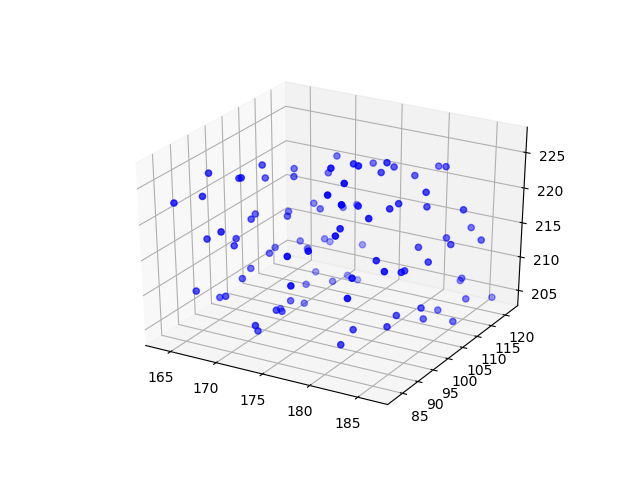

In [52]:
pep = trajectory_dict[0][:96]
zero_c = get_coordinate_from_decomposition(pep)
plot_single_peptide(zero_c)

In [ ]:
a = nv.show_mdanalysis(u)

<IPython.core.display.Javascript object>


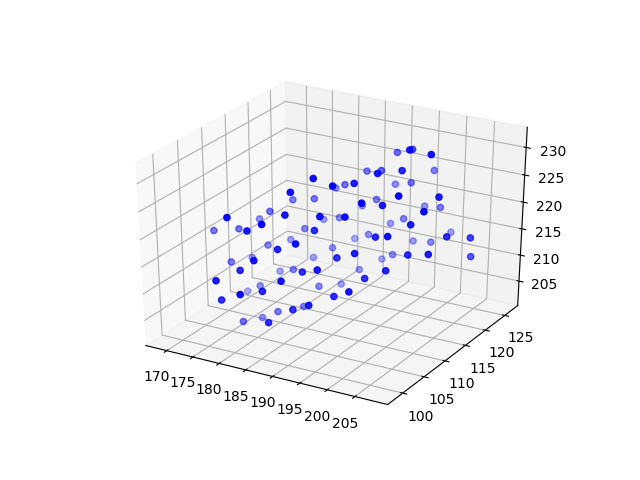

In [53]:
pep = trajectory_dict[1][:96]
uno_c = get_coordinate_from_decomposition(pep)
plot_single_peptide(uno_c)

<IPython.core.display.Javascript object>


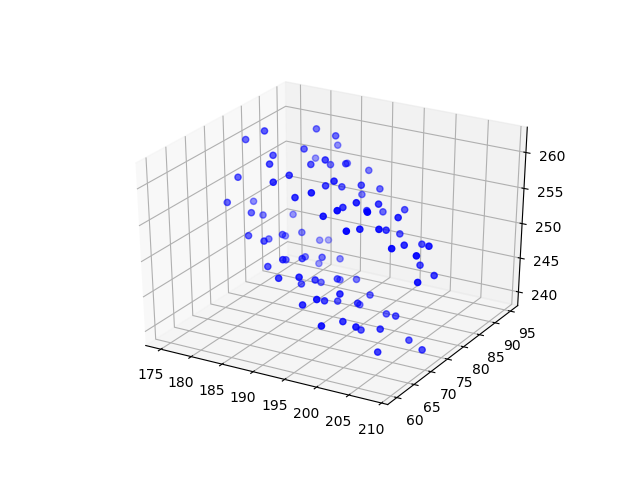

In [54]:
pep = trajectory_dict[6][:96]
sei_c = get_coordinate_from_decomposition(pep)
plot_single_peptide(sei_c)

<IPython.core.display.Javascript object>


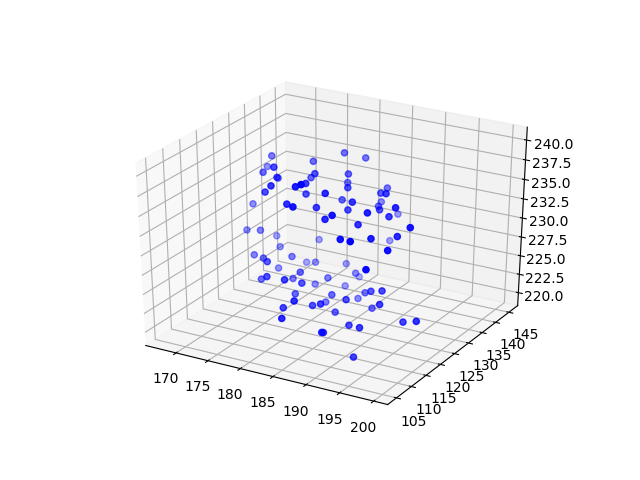

In [55]:
pep = trajectory_dict[15][:96]
quindici_c = get_coordinate_from_decomposition(pep)
plot_single_peptide(quindici_c)

In [56]:
compute_distance_maps_from_gro(zero_c)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [57]:
zero_c

{0: array([168.961,  85.78 , 219.44 ], dtype=float32),
 1: array([166.68298,  87.723  , 217.221  ], dtype=float32),
 2: array([168.461,  90.76 , 215.9  ], dtype=float32),
 3: array([167.39    ,  94.270004, 215.56999 ], dtype=float32),
 4: array([167.974  ,  97.289  , 217.64299], dtype=float32),
 5: array([167.171  , 100.77   , 217.16098], dtype=float32),
 6: array([169.707   , 103.479996, 216.791   ], dtype=float32),
 7: array([168.59999 , 106.979996, 216.15999 ], dtype=float32),
 8: array([171.189  , 109.53   , 216.54999], dtype=float32),
 9: array([169.37898, 112.76   , 215.95   ], dtype=float32),
 10: array([171.591  , 115.75   , 215.12299], dtype=float32),
 11: array([171.87, 119.45, 214.56], dtype=float32),
 12: array([177.15   ,  83.14101, 215.12   ], dtype=float32),
 13: array([176.57999,  83.819  , 218.831  ], dtype=float32),
 14: array([177.52199,  87.359  , 218.79099], dtype=float32),
 15: array([179.45    ,  89.899994, 220.68    ], dtype=float32),
 16: array([178.71701,  93.

In [ ]:
a

In [ ]:
view = nv.show_pdbid('2mcu')

In [ ]:
view

In [ ]:
trj_gro

In [ ]:
gro = read_gro(trj_gro)

In [6]:
# open file .gro and return a list with one element per line of the .gro file
def read_gro(path):
    gromacs_output = open(path)

    gro_file = []
    for line in tqdm.tqdm(gromacs_output):
        gro_file.append(line)



    gromacs_output.close()        

    return gro_file



# return string in a string with numbers
def return_if_string(string):
    digits = []
    for i in string:
        if not i.isdigit():
            digits.append(i)

    string = ''.join(digits)

    return string


# return numbers in a string with numbers
def return_if_digit(string):
    digits = []
    for i in string:
        if i.isdigit():
            digits.append(i)

    string = ''.join(digits)

    return string


# remove first, second and last lines from gro_file and reorder information
def clean_gro_file(gro_file):
    cleaned_gro_file = []
    for aminoacid in tqdm.tqdm(gro_file[2:-1]):
        splitted = aminoacid.split()
        if splitted[1] == 'BB':
            position_in_peptide = return_if_digit(splitted[0])
            residue = return_if_string(splitted[0])
            index = splitted[2]
            x = splitted[3]
            y = splitted[4]
            z = splitted[5]
            cleaned_gro_file.append([index, position_in_peptide, residue, x, y, z])
    return cleaned_gro_file

In [7]:
gro = read_gro(trj_gro)

192300it [00:00, 2303391.15it/s]


In [ ]:
len(gro[:2703])

In [8]:
small = gro[:2703]

In [ ]:
small[-2]

In [9]:
clean = clean_gro_file(small)

100%|██████████| 2700/2700 [00:00<00:00, 256590.48it/s]


In [ ]:
small[2].split()[1] == 'BB'

In [ ]:
len(clean)

In [ ]:
clean[-1]

In [10]:
coordinate_dict = get_coordinate_dict_from_cleaned_gro(clean)

In [ ]:
coordinate_dict

In [ ]:
distance_map = compute_distance_maps_from_gro(coordinate_dict)

In [ ]:
distance_map[0]

In [ ]:
plt.imshow(distance_map[0][0])

In [ ]:
plt.close()

In [ ]:
type(distance_map[0])

In [ ]:
distance_map.shape

In [11]:
coordinate_dict

{0: {0: [16.896, 8.578, 21.944],
  1: [16.668, 8.772, 21.722],
  2: [16.846, 9.076, 21.59],
  3: [16.739, 9.427, 21.557],
  4: [16.797, 9.729, 21.764],
  5: [16.717, 10.077, 21.716],
  6: [16.971, 10.348, 21.679],
  7: [16.86, 10.698, 21.616],
  8: [17.119, 10.953, 21.655],
  9: [16.938, 11.276, 21.595],
  10: [17.159, 11.575, 21.512],
  11: [17.187, 11.945, 21.456],
  12: [17.715, 8.314, 21.512],
  13: [17.658, 8.382, 21.883],
  14: [17.752, 8.736, 21.879],
  15: [17.945, 8.99, 22.068],
  16: [17.872, 9.354, 22.042],
  17: [18.069, 9.646, 22.155],
  18: [17.858, 9.956, 22.181],
  19: [18.096, 10.226, 22.132],
  20: [18.07, 10.597, 22.092],
  21: [18.26, 10.888, 22.223],
  22: [18.201, 11.12, 21.937],
  23: [18.516, 11.335, 21.923],
  24: [18.426, 11.935, 21.472],
  25: [18.62, 11.646, 21.431],
  26: [18.333, 11.388, 21.455],
  27: [18.481, 11.052, 21.501],
  28: [18.227, 10.784, 21.466],
  29: [18.429, 10.471, 21.407],
  30: [18.293, 10.128, 21.344],
  31: [18.369, 9.777, 21.452],
  3

In [14]:
zero = trajectory_dict[0][:96]

In [15]:
zero

array([[168.961   ,  85.78    , 219.44    ],
       [166.68298 ,  87.723   , 217.221   ],
       [168.461   ,  90.76    , 215.9     ],
       [167.39    ,  94.270004, 215.56999 ],
       [167.974   ,  97.289   , 217.64299 ],
       [167.171   , 100.77    , 217.16098 ],
       [169.707   , 103.479996, 216.791   ],
       [168.59999 , 106.979996, 216.15999 ],
       [171.189   , 109.53    , 216.54999 ],
       [169.37898 , 112.76    , 215.95    ],
       [171.591   , 115.75    , 215.12299 ],
       [171.87    , 119.45    , 214.56    ],
       [177.15    ,  83.14101 , 215.12    ],
       [176.57999 ,  83.819   , 218.831   ],
       [177.52199 ,  87.359   , 218.79099 ],
       [179.45    ,  89.899994, 220.68    ],
       [178.71701 ,  93.54    , 220.418   ],
       [180.69    ,  96.46    , 221.54999 ],
       [178.577   ,  99.56    , 221.81    ],
       [180.95999 , 102.259995, 221.32    ],
       [180.70099 , 105.97    , 220.92299 ],
       [182.6     , 108.88    , 222.23    ],
       [18

In [17]:
len(zero) / 12

8.0

In [19]:
aggregate_dict = {}
for i in range(int(len(zero)/12)):
    aggregate_dict[i] = zero[i*12:(i*12 + 12)]
    

In [21]:
len(aggregate_dict[0])

12

In [22]:
aggr_distance = compute_distance_maps_from_gro(aggregate_dict)

IndexError: arrays used as indices must be of integer (or boolean) type

In [24]:
aggregate_dict

{0: array([[168.961   ,  85.78    , 219.44    ],
        [166.68298 ,  87.723   , 217.221   ],
        [168.461   ,  90.76    , 215.9     ],
        [167.39    ,  94.270004, 215.56999 ],
        [167.974   ,  97.289   , 217.64299 ],
        [167.171   , 100.77    , 217.16098 ],
        [169.707   , 103.479996, 216.791   ],
        [168.59999 , 106.979996, 216.15999 ],
        [171.189   , 109.53    , 216.54999 ],
        [169.37898 , 112.76    , 215.95    ],
        [171.591   , 115.75    , 215.12299 ],
        [171.87    , 119.45    , 214.56    ]], dtype=float32),
 1: array([[177.15    ,  83.14101 , 215.12    ],
        [176.57999 ,  83.819   , 218.831   ],
        [177.52199 ,  87.359   , 218.79099 ],
        [179.45    ,  89.899994, 220.68    ],
        [178.71701 ,  93.54    , 220.418   ],
        [180.69    ,  96.46    , 221.54999 ],
        [178.577   ,  99.56    , 221.81    ],
        [180.95999 , 102.259995, 221.32    ],
        [180.70099 , 105.97    , 220.92299 ],
        [18

In [27]:
aggr_dict = get_coordinate_from_decomposition(aggregate_dict[0])

In [29]:
aggr_dict = {}
for i in aggregate_dict:
    aggr_dict[i] = get_coordinate_from_decomposition(aggregate_dict[i])

In [31]:
aggregate_distance = compute_distance_maps_from_gro(aggr_dict)

In [32]:
aggregate_distance

array([[[[ 0.        ,  3.72674225,  6.13042363, ..., 27.20800305,
          30.39333037, 34.14594391],
         [ 3.72674225,  0.        ,  3.75895745, ..., 25.21379265,
          28.53073865, 32.25815168],
         [ 6.13042363,  3.75895745,  0.        , ..., 22.0192006 ,
          25.19723527, 28.92287417],
         ...,
         [27.20800305, 25.21379265, 22.0192006 , ...,  0.        ,
           3.81012742,  7.27277612],
         [30.39333037, 28.53073865, 25.19723527, ...,  3.81012742,
           0.        ,  3.7529681 ],
         [34.14594391, 32.25815168, 28.92287417, ...,  7.27277612,
           3.7529681 ,  0.        ]],

        [[ 9.62737704,  7.89084189,  8.72954817, ..., 26.97066035,
          28.57372748, 31.97743349],
         [11.61753682, 10.76029668, 10.9581654 , ..., 26.94550557,
          28.11948351, 31.65720992],
         [11.58257888, 11.07638179, 10.10080028, ..., 23.83935153,
          24.76711533, 28.28874707],
         ...,
         [30.63270188, 29.9622461 

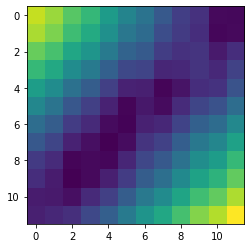

In [42]:
plt.imshow(aggregate_distance[0][7])